In [48]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import math

In [92]:
def histogramImg(mat, K=256):
    r"""Receives a single channel image in matrix form and 
    returns a numpy array of size K, representing the histogram values 
    of the image such that vec[x] = number of points in the image of value x"""
    vec = np.zeros(K)
    for row in mat:
        for value in row:
            vec[value] += 1
    return vec

In [93]:
def setupPlots(numberPlots=1):
    r"""Setups a figure and returns the figure and axis. 
    Receives the number of plots"""
    x = min(2, numberPlots)
    y = int((numberPlots+1)/2) 
    #_ = figure(figsize=(10*x, y*6), dpi=80)
    fig, ax = plt.subplots(y,x, squeeze=False, figsize=(10*x, y*6), dpi=80)
    ax2 = []
    it = 0
    for yy in ax:
        for xx in yy:
            if(it == numberPlots):
                break
            ax2.append(xx)
            it += 1
            

    return fig, ax2

In [94]:
def thresholdImage(img, range :tuple, value, remain = True):
    r"""Receives a single channel Image, a range, and the substitute value. Elements inside (inclusive)
    that range, gets their values replaced by the value specified.
    If remain==True, the remaining pixels conserve its value, otherwise the remaining pixels are reset 2 zero"""

    mask = np.bitwise_and(img<=range[1], img>=range[0])
    mask2 = np.bitwise_not(mask)
    if(remain == False):
        return mask*value
    else:
        return mask*value + img*mask2

In [95]:
def negateImage(img, K=255):
    r"""Returns negated version of image in uint8!!!"""
    img2 = np.int16(img)
    img2 = img2*-1+K
    return np.uint8(img2)

## Part1

1.1) Download the Girl Face image and plot a histogram of the grey levels it contains.

 (Try plotting a histrogram of another grey scale image and comparing the difference) 

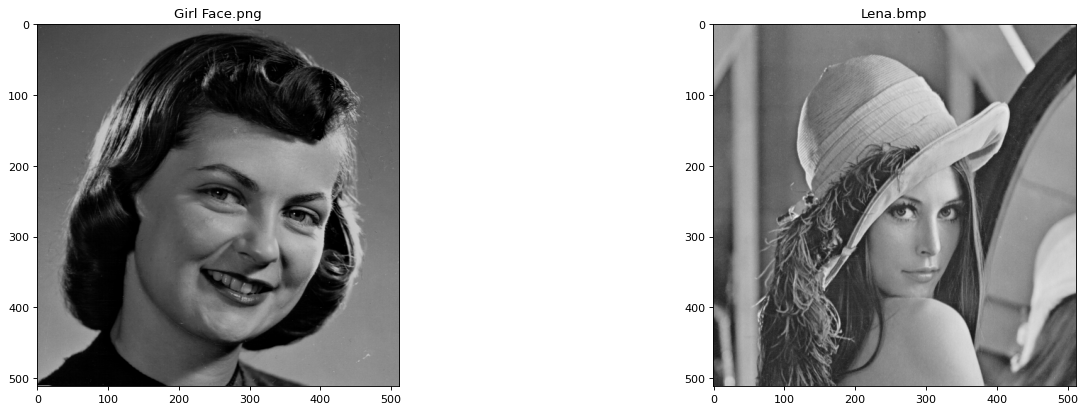

In [96]:
imgNames = ['Girl Face.png', 'Lena.bmp']
imgPath = '../dataset/'
imgs = []
N = len(imgNames)
for imgName in imgNames:
    imgBGR = cv2.imread(imgPath + imgName)
    # imgBW = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2GRAY)
    imgs.append(imgBGR)
fig, ax = setupPlots(N)
for axes, img, name in zip(ax, imgs, imgNames):
    axes.imshow(img)
    axes.set_title(name)

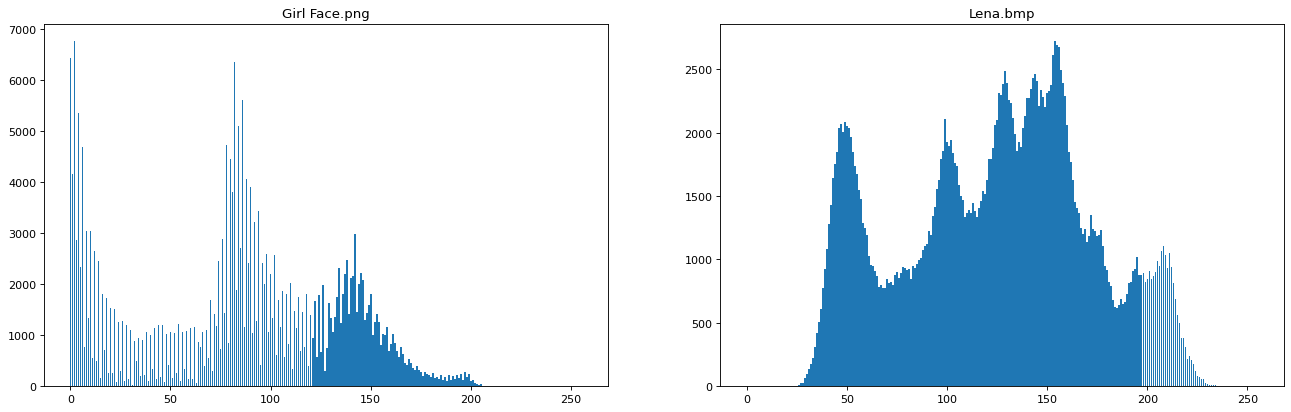

In [97]:
histograms = []
colorRange = 256
for img in imgs:
    histogram = histogramImg(img, colorRange)
    histograms.append(histogram)
fig, ax = setupPlots(N)
for axes, hist, name in zip(ax, histograms, imgNames):
    axes.bar(np.arange(colorRange), hist)
    axes.set_title(name)

##### Comparison
The Girl face histogram has a lot of pixels in the darker spectrum (pixel values from 0 to 5). Also it doesn't have any pixels with value greater than 200. The image doesn have a uniform distribution in its histogram, and it can be assumed that it could use the range of the spectrum better. A Logarithmic Full Spectrum Stretch might be helpful to improve this image, since it needs to expand the dim values of the image.

#### Lena histogram
The leena histogram is more uniform, it is missing values in ranges from [0-20] and from [220-255]. This image could use a FHSH to improve

## Excercise 1.2)
1.2) Write a short program to threshold the image and try to identify a good threshold by trial and error. Create a ground truth segmentation

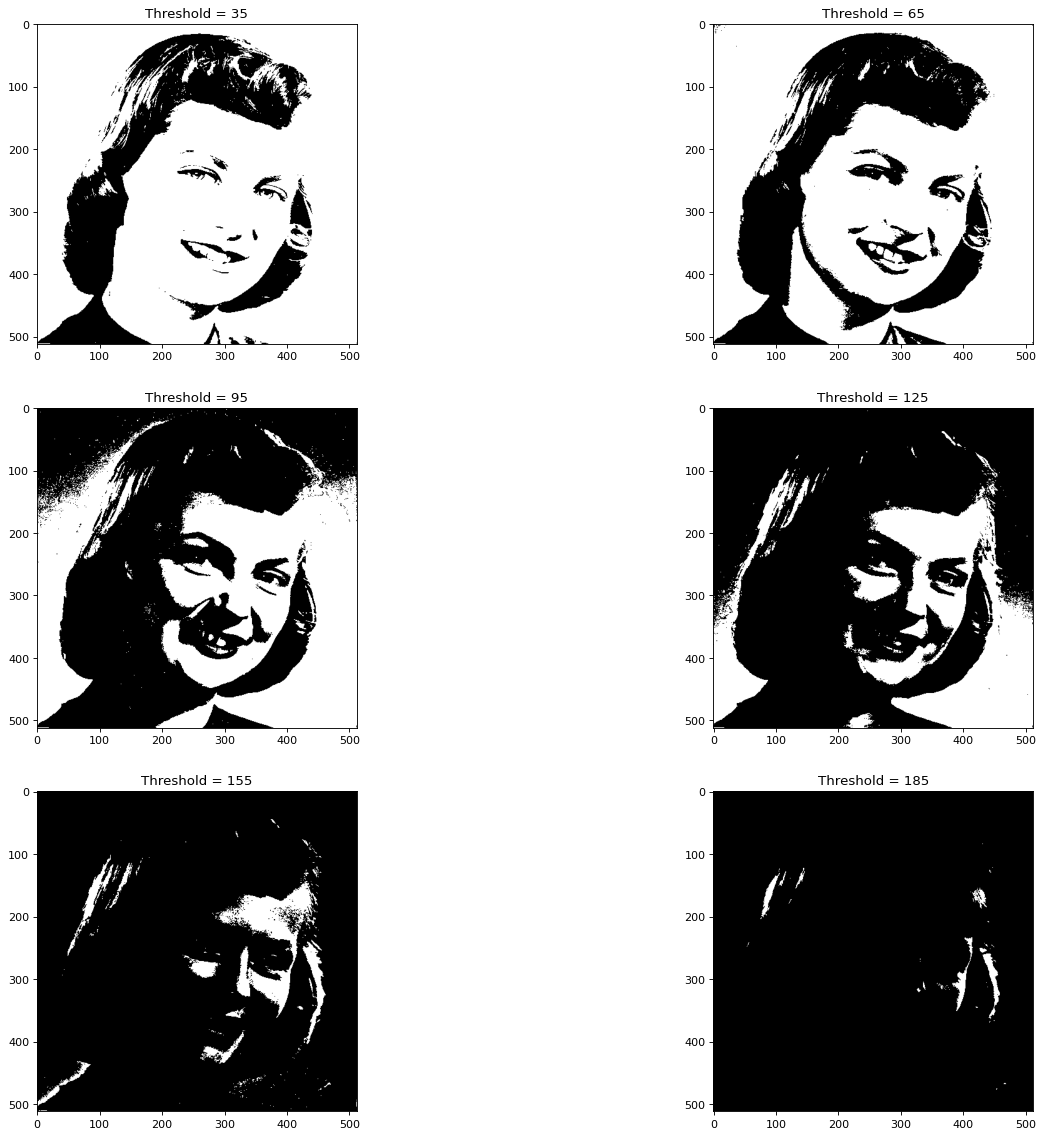

In [98]:
img = imgs[0]
name = imgNames[0]
thresholds = [(0,x) for x in range(35,200,30)]
namesThreshold = [str(x[1]) for x in thresholds]
imgsThresh = []
for threshHold in thresholds:
    newImg = negateImage(thresholdImage(img, threshHold, colorRange-1, remain=False))
    imgsThresh.append(newImg)

fig, ax = setupPlots(len(thresholds))
for axes, im, tr in zip(ax, imgsThresh, namesThreshold):
    axes.imshow(im)
    axes.set_title('Threshold = ' + tr)

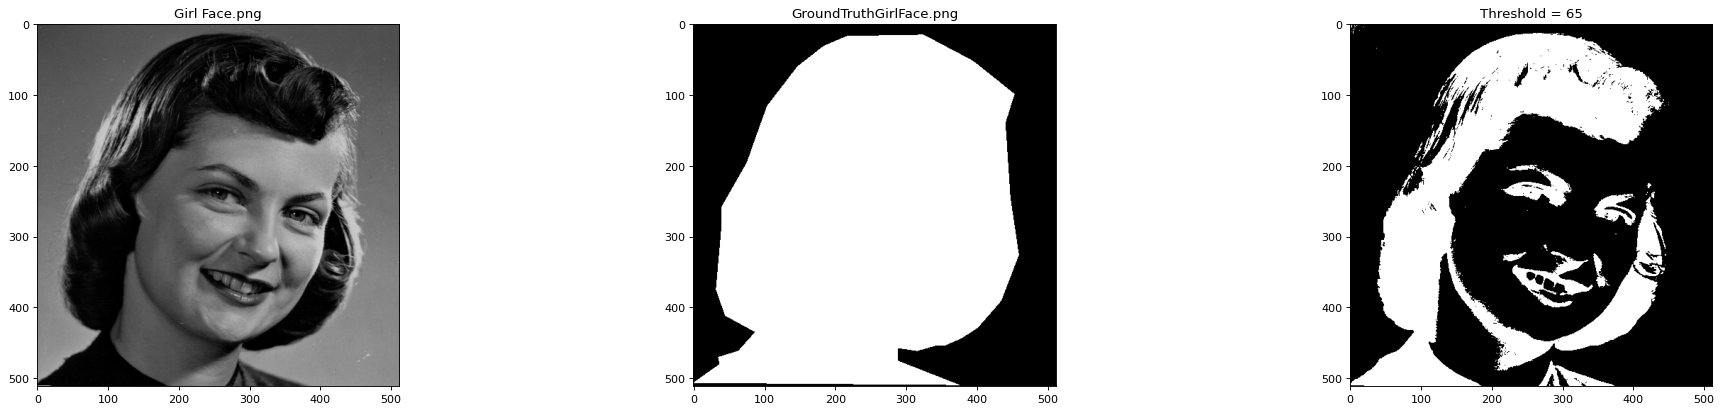

In [200]:
groundTruthName = 'GroundTruthGirlFace.png'
groundTruth = cv2.imread(imgPath + groundTruthName)
for i,a in enumerate(groundTruth):
    for j,b in enumerate(a):
        if(b[0] >= colorRange/2):
            groundTruth[i][j][0] = colorRange-1
            groundTruth[i][j][1] = colorRange-1
            groundTruth[i][j][2] = colorRange-1
        else:
            groundTruth[i][j][0] = 0
            groundTruth[i][j][1] = 0
            groundTruth[i][j][2] = 0
goodThreshold = thresholdImage(img, (0,65), colorRange-1, False)
fig, ax = plt.subplots(1,3,squeeze=True, figsize=(30, 6), dpi=80)

ax[0].imshow(img)
ax[0].set_title(name)

ax[1].imshow(groundTruth)
ax[1].set_title(groundTruthName)

ax[2].imshow(goodThreshold)
ax[2].set_title('Threshold = 65')
plt.show()


## Ejericio 1.3)
Use your ground truth segmentation to plot an ROC curve for your thresholding algorithm. What threshold does the ROC curve suggest does the ROC curve suggest? You may have to implement an algorithm to find the point closest to a desired Oparating Point. How does it compare to your trial and error estimate?

$$ \begin{align*} SegX[i] &= number\_ of\_ pixels\_ in\_ segment <= i \\
NSegX[i] &= number \_ of \_ pixels \_ out \_ of \_ segment <= i \\
TP(x) &= SegX[x] \\
FP(x) &= NSegX[x] \\
FN(x) &= SegX[ColorRange-1] - SegX[x] \\
TN(x) &= NSegX[ColorRange-1] - NSegX[x]

\end{align*}$$

$TP$ are True Positives, $FP$ False Positives, $TN$ True Negatives and $FN$ False Negatives


$$ \begin{align*} TPR &= \frac{TP}{TP + FN} \\
FPR &= \frac{FP}{FP + TN} \end{align*} $$
Where $TPR$ is the True positive Rate and $FPR$ is the false positive rate

Note: For inverse ROC curve excchange $TPR$ and $FPR$

In [267]:
# Get FPR and TPR
SegX = np.zeros((colorRange))
NSegX = np.zeros((colorRange))
for a,c in zip(groundTruth, img):
    for truth, pixel in zip(a, c):
        truth = truth[0]
        if(truth == colorRange-1):
            SegX[pixel] += 1
        elif(truth == 0):
            NSegX[pixel] += 1
        else:
            print('error')
for i in range(1,colorRange):
    SegX[i] += SegX[i-1]
    NSegX[i] += NSegX[i-1]

def TPR(x):
    FalseNegatives = SegX[colorRange-1]-SegX[x]
    return SegX[x]/(SegX[x] + FalseNegatives)

def FPR(x):
    TrueNegatives = NSegX[colorRange - 1]-NSegX[x]
    return NSegX[x]/(NSegX[x] + TrueNegatives)

def InverseTPR(x):
    TruePositives = SegX[colorRange-1]-SegX[x]
    FalseNegatives = SegX[x]
    return TruePositives/(TruePositives + FalseNegatives)

def InverseFPR(x):
    TrueNegatives = NSegX[x]
    FalsePositives = NSegX[colorRange-1]-NSegX[x]
    return FalsePositives/(FalsePositives + TrueNegatives)
    


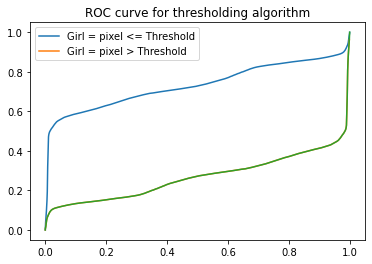

In [300]:
# Plot TPR and FPR for all thresholds
YY = [TPR(x) for x in range(colorRange)]
XX  = [FPR(x) for x in range(colorRange)]
Y = [0]
X = [0]
Y.extend(YY)
X.extend(XX)
X2 = [InverseFPR(x) for x in range(colorRange)]
Y2 = [InverseTPR(x) for x in range(colorRange)]
X2.append(0)
Y2.append(0)
fig, ax = plt.subplots(1,1,squeeze=True)
ax.plot(X,Y, label='Girl = pixel <= Threshold')
ax.plot(X2,Y2, label='Girl = pixel > Threshold')
#X3 = 1-np.array(X)
#Y3 = 1-np.array(Y)
#ax.plot(X3,Y3)
#ax.legend()
ax.set_title('ROC curve for thresholding algorithm')

plt.show()

In [301]:
#Calculate Distance from optimal point (Where TPR = 1 and FPR = 0) for all ROC points
disA = 1
disB = 1
maxA = -1
maxB = -1
disC = 1
maxC = -1
X3 = (1-np.array(X))
Y3 = (1-np.array(Y))
for i in range(colorRange + 1):
    propA = (0-X[i])**2+(1-Y[i])**2
    propA = math.sqrt(propA)
    if(disA > propA):
        disA = propA
        maxA = i
    propB = (0-X2[i])**2+(1-Y2[i])**2
    propB = math.sqrt(propB)
    if(disB > propB):
        disB = propB
        maxB = i
    
    #propC = (0-X3[i])**2+(1-Y3[i])**2
    #propC = math.sqrt(propC)
    #if(disC > propC):
    #    disC = propC
    #    maxC = i
    
print("Distance:", disA, "ThreshHold <= ",maxA)
print("Distance:", disB, "ThreshHold >" ,maxB)
#print("Distance:", disC, "ThreshHold >" ,maxC-1)

Distance: 0.42116800749055694 ThreshHold <=  83
Distance: 0.867775280304501 ThreshHold > 115
Distance: 0.867775280304501 ThreshHold > 115


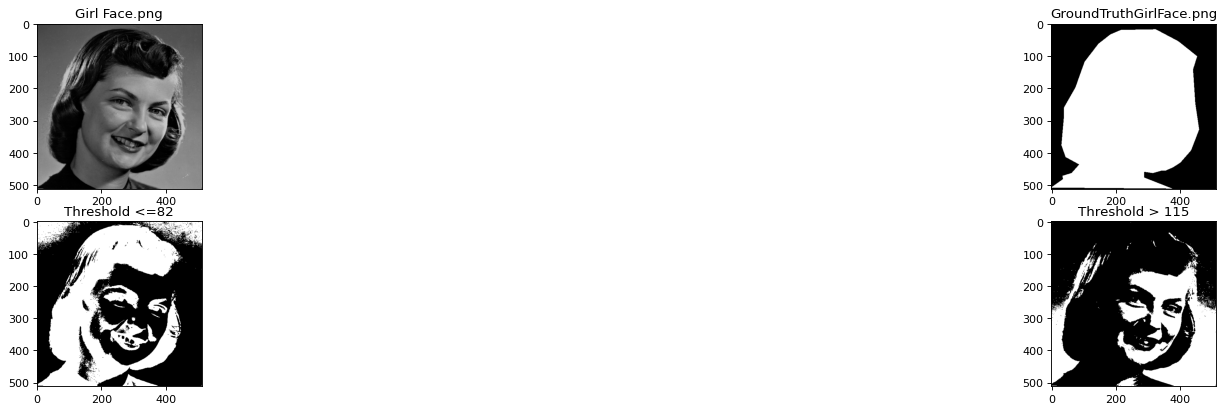

In [297]:
groundTruthName = 'GroundTruthGirlFace.png'
goodThreshold = thresholdImage(img, (0, maxA-1), colorRange-1, False)
goodInvesrseThreshold = negateImage(thresholdImage(img, (0, maxB), colorRange-1, False))
fig, ax = plt.subplots(2,2,squeeze=True, figsize=(30, 6), dpi=80)
gTruth2 = groundTruth
ax[0][0].imshow(img)
ax[0][0].set_title(name)

ax[0][1].imshow(groundTruth)
ax[0][1].set_title(groundTruthName)

ax[1][0].imshow(goodThreshold)
ax[1][0].set_title('Threshold <=' + str(maxA-1))

ax[1][1].imshow(goodInvesrseThreshold)
ax[1][1].set_title('Threshold > ' + str(maxB))
#ax[1][1].imshow(secondThreshold)
#ax[1][1].set_title('Threshold >' + )

plt.show()


Conclusion. Threshold <=82 is the best threshold